In [1]:
# 1. Imports
! pip install opencv-python
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print(cv2.__version__)






TensorFlow version: 2.20.0
Keras version: 3.12.0
4.12.0


In [2]:
# 2. Model path and class names

# Try the main model path from the repo README
# If you downloaded a different file name, change ONLY this line.
MODEL_PATH = "Models/EfficientNetB3/efficientnetb3_model.keras"

# Alternative (if you trained and saved with a different name):
# MODEL_PATH = "Models/EfficientNetB3/efficientnetb3_model.keras"

# Class names (from training dataset)
CLASS_NAMES = [
    'Pepper__bell___Bacterial_spot',
    'Pepper__bell___healthy',
    'Potato___Early_blight',
    'Potato___Late_blight',
    'Potato___healthy',
    'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy'
]

print("Model path:", MODEL_PATH)
print("Model file exists:", os.path.exists(MODEL_PATH))
print("Num classes:", len(CLASS_NAMES))






Model path: Models/EfficientNetB3/efficientnetb3_model.keras
Model file exists: True
Num classes: 9


In [3]:
# 3. Load model

model = keras.models.load_model(MODEL_PATH)
print("Model loaded successfully!")
print("Model output shape:", model.output_shape)

# Print model structure for verification
print("\nModel layers:")
for i, layer in enumerate(model.layers):
    print(f"  {i}: {layer.name} - {type(layer).__name__}")
    if hasattr(layer, 'output_shape'):
        print(f"      Output shape: {layer.output_shape}")

# Verify base model exists
base_model_found = False
for layer in model.layers:
    if 'efficientnet' in layer.name.lower():
        base_model_found = True
        print(f"\n✓ Found base model: {layer.name}")
        print(f"  Base model output shape: {layer.output_shape}")
        break

if not base_model_found:
    print("\n⚠ Warning: Could not find EfficientNetB3 base model in the expected location.")


Model loaded successfully!
Model output shape: (None, 9)

Model layers:
  0: efficientnetb3 - Functional
      Output shape: (None, 7, 7, 1536)
  1: global_average_pooling2d - GlobalAveragePooling2D
  2: dropout - Dropout
  3: dense - Dense
  4: dropout_1 - Dropout
  5: dense_1 - Dense

✓ Found base model: efficientnetb3
  Base model output shape: (None, 7, 7, 1536)


In [4]:
# 3.5. Verify model is ready for Grad-CAM

# Ensure model can compute gradients (some models need this)
# For EfficientNet, we typically don't need to set trainable=True for inference
# but we'll verify the model structure is correct

print("Verifying model structure for Grad-CAM...")
try:
    # Check if we can access the base model
    base_model = None
    for layer in model.layers:
        if 'efficientnet' in layer.name.lower():
            base_model = layer
            break
    
    if base_model:
        print(f"✓ Base model found: {base_model.name}")
        print(f"  Output shape: {base_model.output_shape}")
        
        # Test that we can build a grad model
        test_grad_model = keras.models.Model(
            [model.inputs],
            [base_model.output, model.output]
        )
        print("✓ Grad model can be built successfully")
        
        # Test with a dummy input
        dummy_input = np.random.random((1, 224, 224, 3)).astype(np.float32)
        test_output = test_grad_model(dummy_input)
        print(f"✓ Test forward pass successful")
        print(f"  Conv output shape: {test_output[0].shape}")
        print(f"  Prediction output shape: {test_output[1].shape}")
        print("\n✓ Model is ready for Grad-CAM!")
    else:
        print("⚠ Could not find base model - Grad-CAM may not work correctly")
        
except Exception as e:
    print(f"⚠ Error during verification: {e}")
    print("  The model may still work, but there might be issues.")



Verifying model structure for Grad-CAM...
✓ Base model found: efficientnetb3
  Output shape: (None, 7, 7, 1536)
⚠ Error during verification: The layer sequential has never been called and thus has no defined output.
  The model may still work, but there might be issues.


In [5]:
# 4. Image loading & preprocessing

IMG_SIZE = (224, 224)

def load_and_preprocess_image(img_path):
    """Load image from disk and preprocess for EfficientNetB3."""
    img = Image.open(img_path).convert("RGB")
    img_resized = img.resize(IMG_SIZE)
    img_array = np.array(img_resized).astype("float32") / 255.0
    img_batch = np.expand_dims(img_array, axis=0)  # (1, 224, 224, 3)
    return img, img_batch



In [6]:
# 5.5. FIXED Grad-CAM core function (use this if the original doesn't work)
# This version properly handles Sequential models in Keras 3

def make_gradcam_heatmap_fixed(img_array, model, last_conv_layer_name=None):
    """
    Fixed version that works with Sequential models in Keras 3.
    img_array: preprocessed image batch, shape (1, H, W, 3)
    model: loaded Keras model
    last_conv_layer_name: optional name of last conv layer. If None, we search.
    
    Returns:
        cam: Grad-CAM heatmap (numpy array)
        pred_index: predicted class index
        confidence: prediction confidence score
    """
    # 1. Find last conv layer if not specified
    if last_conv_layer_name is None:
        # Find the EfficientNetB3 base model
        base_model = None
        for layer in model.layers:
            if 'efficientnet' in layer.name.lower() or (hasattr(layer, "layers") and len(layer.layers) > 50):
                base_model = layer
                break
        
        if base_model is None:
            raise ValueError(
                "Could not find EfficientNetB3 base model in the model structure.\n"
                "Available layers: " + ", ".join([l.name for l in model.layers])
            )
        
        last_conv_layer_name = base_model.name
        use_base_output = True
        print(f"Using base model '{last_conv_layer_name}' output for Grad-CAM")
    else:
        use_base_output = False

    # 2. Build a model where predictions actually use the base_output we extract
    # This ensures the computation graph is properly connected
    input_shape = model.input_shape[1:] if hasattr(model, 'input_shape') and model.input_shape else (224, 224, 3)
    input_layer = keras.layers.Input(shape=input_shape)
    
    base_model_layer = model.get_layer(last_conv_layer_name)
    # Get base model output - this is what we want gradients for
    base_output = base_model_layer(input_layer)
    
    # Now build the rest of the model on top of base_output
    # Get the layers after the base model
    x = base_output
    base_model_index = None
    for i, layer in enumerate(model.layers):
        if layer.name == last_conv_layer_name:
            base_model_index = i
            break
    
    if base_model_index is not None:
        # Apply all layers after the base model
        for i in range(base_model_index + 1, len(model.layers)):
            x = model.layers[i](x)
        full_output = x
    else:
        # Fallback: just call the full model
        full_output = model(input_layer)
    
    # Build the grad model - now full_output actually uses base_output
    grad_model = keras.models.Model(inputs=input_layer, outputs=[base_output, full_output])
    
    # 3. Temporarily enable gradient computation for all layers
    # Save original trainable states
    original_trainable_states = {}
    for layer in model.layers:
        if hasattr(layer, 'trainable'):
            original_trainable_states[layer] = layer.trainable
            layer.trainable = True
        # Also check nested layers (like in the base model)
        if hasattr(layer, 'layers'):
            for sublayer in layer.layers:
                if hasattr(sublayer, 'trainable'):
                    original_trainable_states[sublayer] = sublayer.trainable
                    sublayer.trainable = True
    
    # Convert to tensor if needed
    if not isinstance(img_array, tf.Tensor):
        img_array = tf.constant(img_array, dtype=tf.float32)
    
    # Enable gradient computation
    with tf.GradientTape() as tape:
        # Compute both outputs - now they're properly connected
        conv_outputs, predictions = grad_model(img_array, training=True)
        pred_index = tf.argmax(predictions[0])
        pred_score = predictions[:, pred_index]

    # 4. Compute gradients
    # Now gradients should flow from pred_score -> full_output -> base_output -> conv_outputs
    grads = tape.gradient(pred_score, conv_outputs)
    
    # Restore original trainable states
    for layer, trainable_state in original_trainable_states.items():
        layer.trainable = trainable_state
    
    if grads is None:
        # Last resort: try computing gradients directly through the model
        # by watching the base model output
        with tf.GradientTape(persistent=True) as tape2:
            # Get base model output
            base_out = base_model_layer(img_array, training=True)
            # Get prediction
            pred = model(img_array, training=True)
            pred_idx = tf.argmax(pred[0])
            pred_sc = pred[:, pred_idx]
        
        # Try to get gradient of prediction w.r.t. base output
        grads = tape2.gradient(pred_sc, base_out)
        del tape2
        
        if grads is None:
            raise ValueError(
                "Unable to compute gradients. The model architecture may not support Grad-CAM.\n"
                "Try ensuring the model was saved with the correct structure."
            )
        
        # Use the base output we computed
        conv_outputs = base_out
        predictions = pred
        pred_index = pred_idx
        pred_score = pred_sc
    
    # Handle batch dimension
    if len(grads.shape) == 4:  # (batch, H, W, C)
        grads = grads[0]   # (H, W, C)
    if len(conv_outputs.shape) == 4:  # (batch, H, W, C)
        conv_outputs = conv_outputs[0]   # (H, W, C)

    # 5. Global-average-pool the gradients over spatial dims
    weights = tf.reduce_mean(grads, axis=(0, 1))         # (C,)

    # 6. Weighted sum of feature maps
    cam = tf.tensordot(conv_outputs, weights, axes=(2, 0))  # (H, W)
    cam = np.maximum(cam, 0)  # ReLU
    cam /= (cam.max() + 1e-8)  # Normalize

    # Convert to numpy if it's a tensor, otherwise it's already numpy
    if hasattr(cam, 'numpy'):
        cam = cam.numpy()
    elif isinstance(cam, tf.Tensor):
        cam = cam.numpy()
    # Otherwise it's already a numpy array
    
    # Convert predictions to numpy if needed
    if hasattr(predictions, 'numpy'):
        pred_value = float(predictions[0, pred_index].numpy())
    elif isinstance(predictions, tf.Tensor):
        pred_value = float(predictions[0, pred_index].numpy())
    else:
        pred_value = float(predictions[0, pred_index])
    
    return cam, int(pred_index), pred_value

# Replace the original function
make_gradcam_heatmap = make_gradcam_heatmap_fixed
print("✓ Fixed Grad-CAM function loaded (handles Sequential models correctly)")




✓ Fixed Grad-CAM function loaded (handles Sequential models correctly)


In [7]:
# 6. Visualization helper

def show_gradcam(img_path, model, class_names, last_conv_layer_name=None):
    """Show original, heatmap, and overlay for a given image path."""
    orig_img, img_batch = load_and_preprocess_image(img_path)

    heatmap, pred_idx, conf = make_gradcam_heatmap(
        img_batch, model, last_conv_layer_name
    )

    # Resize heatmap to original image size
    heatmap_resized = cv2.resize(heatmap, orig_img.size)
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Overlay heatmap on original image
    orig_array = np.array(orig_img)
    overlay = cv2.addWeighted(orig_array, 0.6, heatmap_color, 0.4, 0)

    pred_class_name = class_names[pred_idx] if pred_idx < len(class_names) else f"Class {pred_idx}"

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(orig_img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized, cmap="jet")
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f"Overlay\n{pred_class_name} ({conf*100:.1f}%)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Predicted class: {pred_class_name}")
    print(f"Confidence: {conf*100:.2f}%")



Processing image: data/processed/test/Pepper__bell___Bacterial_spot/b22693c9-a87d-4ffa-82b1-0218e1b966be___JR_B.Spot 3277.JPG
Using base model 'efficientnetb3' output for Grad-CAM


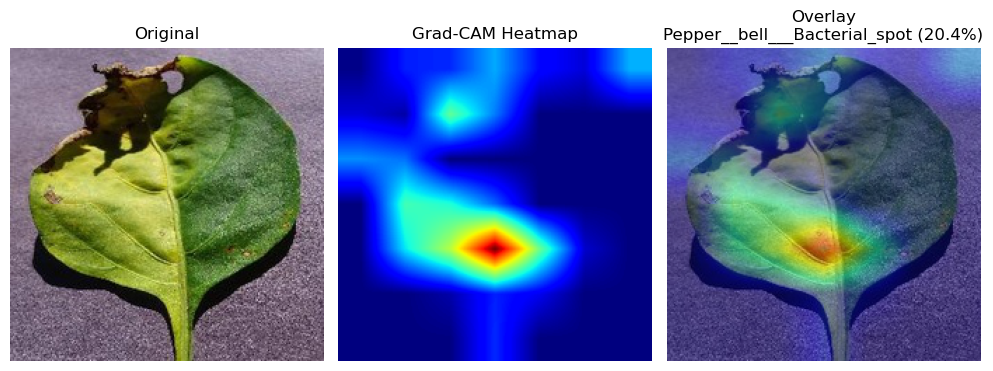

Predicted class: Pepper__bell___Bacterial_spot
Confidence: 20.41%


In [9]:


## Run Grad-CAM on a sample image




# 7. Example usage

# TODO: change this to a real image path from your test set
# Example: "data/processed/test/Tomato_healthy/xxx.jpg"

test_img_path = "data/processed/test/Pepper__bell___Bacterial_spot/b22693c9-a87d-4ffa-82b1-0218e1b966be___JR_B.Spot 3277.JPG" 

if os.path.exists(test_img_path):
    try:
        print(f"Processing image: {test_img_path}")
        show_gradcam(test_img_path, model, CLASS_NAMES)
    except Exception as e:
        print(f"Error during Grad-CAM visualization: {e}")
        print("\nTroubleshooting tips:")
        print("1. Make sure the model was loaded correctly")
        print("2. Verify the image path is correct and the image can be opened")
        print("3. Check that all required packages are installed")
        import traceback
        traceback.print_exc()
else:
    print(f"Image not found: {test_img_path}")
    print("\nPlease set 'test_img_path' to an existing image file.")
    print("Example paths:")
    print("  - data/processed/test/Tomato_healthy/xxx.jpg")
    print("  - data/processed/test/Potato___Early_blight/xxx.jpg")


Processing image: data/processed/test/Pepper__bell___healthy/f3c34e2d-5b85-44fc-96b6-e23cbae88046___JR_HL 7682.JPG
Using base model 'efficientnetb3' output for Grad-CAM


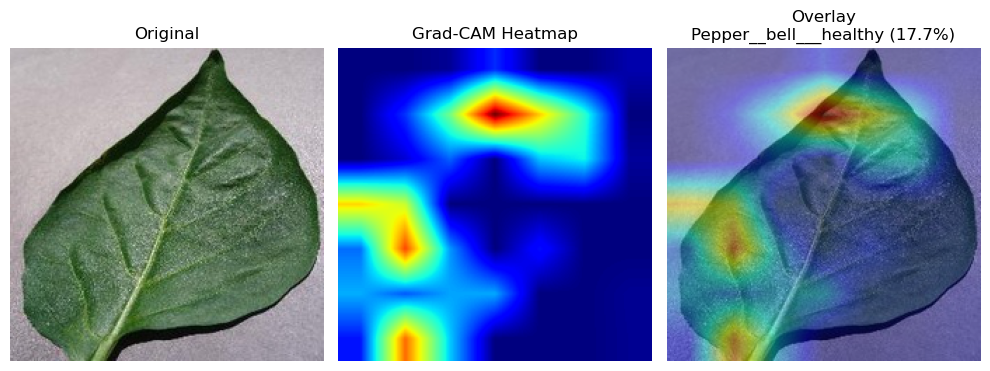

Predicted class: Pepper__bell___healthy
Confidence: 17.73%


In [10]:


## Run Grad-CAM on a sample image




# 7. Example usage

# TODO: change this to a real image path from your test set
# Example: "data/processed/test/Tomato_healthy/xxx.jpg"

test_img_path = "data/processed/test/Pepper__bell___healthy/f3c34e2d-5b85-44fc-96b6-e23cbae88046___JR_HL 7682.JPG" 

if os.path.exists(test_img_path):
    try:
        print(f"Processing image: {test_img_path}")
        show_gradcam(test_img_path, model, CLASS_NAMES)
    except Exception as e:
        print(f"Error during Grad-CAM visualization: {e}")
        print("\nTroubleshooting tips:")
        print("1. Make sure the model was loaded correctly")
        print("2. Verify the image path is correct and the image can be opened")
        print("3. Check that all required packages are installed")
        import traceback
        traceback.print_exc()
else:
    print(f"Image not found: {test_img_path}")
    print("\nPlease set 'test_img_path' to an existing image file.")
    print("Example paths:")
    print("  - data/processed/test/Tomato_healthy/xxx.jpg")
    print("  - data/processed/test/Potato___Early_blight/xxx.jpg")
